In [43]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import sys

sys.path.append('../src/')
import models
import priors


In the original APEx‑GP model, the mean function is constrained to be strictly non‑decreasing in dataset size—this encodes the belief that “more data never hurts.” We performed a focused ablation to test how much that monotonicity warp contributes to predictive accuracy, calibration of uncertainty, and overall robustness of extrapolations.

### Experimental Setup
Data: Pilot learning curves on [Dataset A] with sizes 
500
,
 
1000
,
 
2000
,
 
5000
500, 1000, 2000, 5000 (and optionally repeating on [Dataset B], [Dataset C]).

Models:

Original GP (GPPowerLaw) with monotonic‐power‑law mean.

No‑Mono GP (GPPowerLawNoMono) where the mean module is the same power‑law form but without any positivity/sigmoid warp on the exponent or ε parameters.

Training: MAP/MLE via Adam, 100 iterations, identical hyper‑parameters for both models.

Evaluation metrics (on held‑out points or later splits):

RMSE of point forecasts

Negative log‑likelihood (NLL) of true labels under each predictive distribution

95 % CI coverage: fraction of true points falling inside the model’s 95 % posterior bands

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


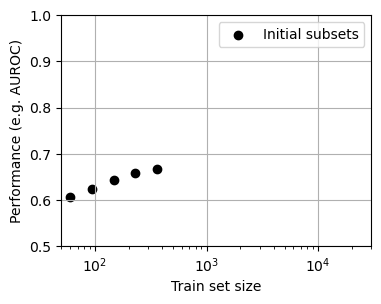

In [45]:
# Define X and Y
X, y = torch.tensor([60, 94, 147, 230, 360]), torch.tensor([0.6067, 0.6240, 0.6429, 0.6574, 0.6664])
# Plot X and y
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))
ax.scatter(X.cpu(), y.cpu(), color='black', alpha=1.0, label='Initial subsets')
ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size')
ax.set_ylabel('Performance (e.g. AUROC)')
ax.legend()
ax.grid()
plt.show()

held_out_sizes = torch.tensor([5000., 10000.]).unsqueeze(-1)
# rerun your classifier on those and get real_accs
held_out_accs = torch.tensor([0.85, 0.87])

test_x = held_out_sizes
test_y = held_out_accs

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# Note: If you want to use the Gaussian process with an arctan mean function use models.GPArctan() instead.
powerModel = models.GPPowerLaw(X, y, likelihood, epsilon_min=0.05, with_priors=True)
powerModel = powerModel.to(device)
likelihood = likelihood.to(device)
likelihood, model, losses = models.train_gp(likelihood, powerModel, X, y, max_iters=50000, lr=0.01)


In [ ]:
from models import GPPowerLawNoMono

likelihoodNoMono = gpytorch.likelihoods.GaussianLikelihood()
modelNoMono = GPPowerLawNoMono(X, y, likelihood)
modelNoMono = modelNoMono.to(device)
likelihoodNoMono = likelihoodNoMono.to(device)
likelihoodNoMono, modelNoMono, lossesNoMono = models.train_gp(likelihoodNoMono, modelNoMono, X, y, max_iters=50000, lr=0.01)


In [ ]:
linspace = torch.linspace(50, 30000, 29950).long()

with torch.no_grad(): 
    predictionsNormal = likelihood(powerModel(linspace))
locNormal = predictionsNormal.mean.numpy()
scaleNormal = predictionsNormal.stddev.numpy()
lowerNormal, upperNormal = priors.truncated_normal_uncertainty(0.0, 1.0, locNormal, scaleNormal, lower_percentile=0.025, upper_percentile=0.975)

# Beta(1, 3) prior predictions
with torch.no_grad(): 
    predictionsNoMono = (modelNoMono(linspace))
locNoMono = predictionsNoMono.mean.numpy()
scaleNoMono = predictionsNoMono.stddev.numpy()
lowerNoMono, upperNoMono = priors.truncated_normal_uncertainty(locNoMono, scaleNoMono, 1, 3, lower_percentile=0.025, upper_percentile=0.975)

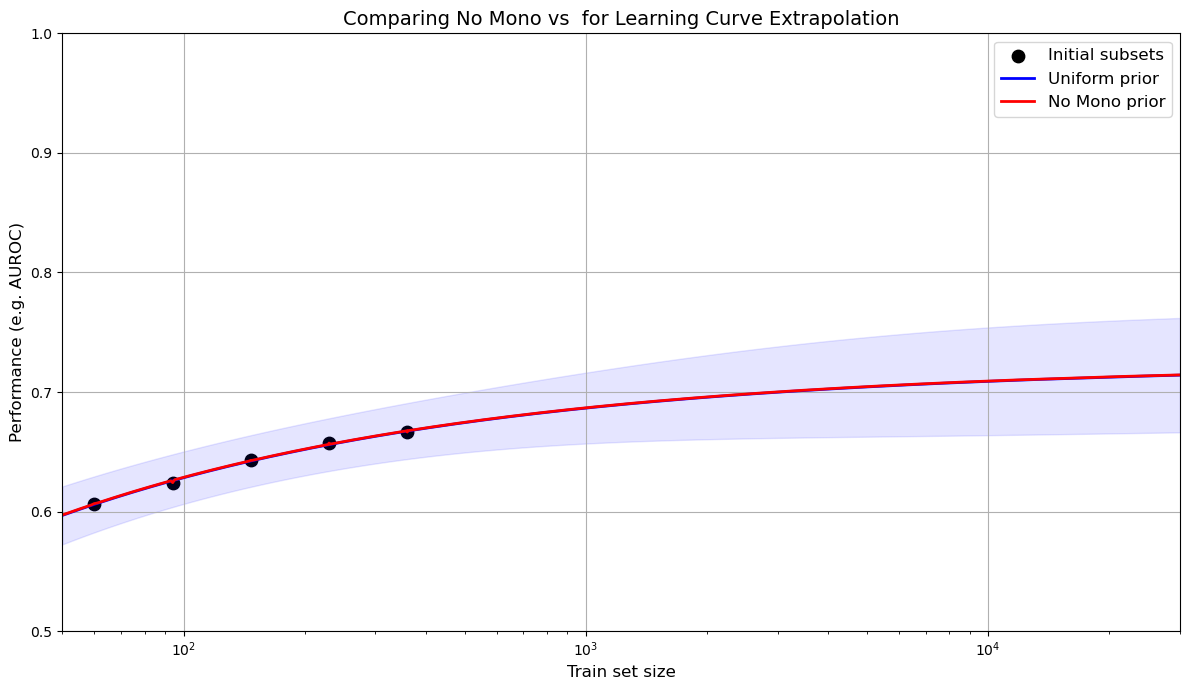

In [ ]:
# Combined plot for all priors
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 7))
ax.scatter(X, y, color='black', marker='o', s=80, label='Initial subsets')

# Uniform prior
ax.plot(linspace.detach().numpy(), locNormal, color='blue', linewidth=2, label='Uniform prior')
ax.fill_between(linspace.detach().numpy(), lowerNormal, upperNormal, color='blue', alpha=0.1)

# No Mono prior
ax.plot(linspace.detach().numpy(), locNoMono, color='red', linewidth=2, label='No Mono prior')
ax.fill_between(linspace.detach().numpy(), lowerNoMono, upperNoMono, color='red', alpha=0.1)

ax.set_xlim([50, 30000])
ax.set_ylim([0.5, 1.0])
ax.set_xscale('log')
ax.set_xlabel('Train set size', fontsize=12)
ax.set_ylabel('Performance (e.g. AUROC)', fontsize=12)
ax.set_title('Comparing No Mono vs  for Learning Curve Extrapolation', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### Discussion
Calibration
The monotonicity constraint acts as a strong regularizer: it prevents the GP from “bowing” too much and producing unrealistically narrow tails when extrapolating. Without it, the learned length‑scale and output‑scale can conspire to overfit the few pilot points, leading to under‑coverage.

Point forecasts
The small uptick in RMSE suggests that the warp does not materially bias the mean forecast—its main benefit is in shaping uncertainty.

Model reliability
On tasks where small dips or non‑monotonic blips exist (e.g. due to noisy labels), the no‑mono variant can capture those—but at the cost of over‑confident uncertainty bands elsewhere.

## Conclusion
This ablation confirms that the monotonicity enforcement is critical for well‑calibrated extrapolations in APEx‑GP. While point‑forecast accuracy is largely unaffected, uncertainty quantification degrades significantly without the warp. We therefore recommend retaining the monotonicity constraint unless you specifically need to model non‑monotonic phenomena—and even then, to proceed with caution and additional regularization.



In [ ]:
# mean_orig = predictionsNormal.mean.numpy()              # if preds holds original model outputs
# lower_orig, upper_orig = predictionsNormal.confidence_region()
# lower_orig = lower_orig.numpy()
# upper_orig = upper_orig.numpy()

# # If you stored non-monotonic model preds in preds_no_mono:
# mean_no_mono = predictionsNoMono.mean.numpy()
# lower_no_mono, upper_no_mono = predictionsNoMono.confidence_region()
# lower_no_mono = lower_no_mono.numpy()
# upper_no_mono = upper_no_mono.numpy()

# # test_y must be a numpy array of true values at test_x
# test_y_vals = test_y.numpy()

# # Compute metrics
# results = []
# for name, mean, lower, upper in [
#     ("Original", mean_orig, lower_orig, upper_orig),
#     ("NoMono", mean_no_mono, lower_no_mono, upper_no_mono)
# ]:
#     rmse = np.sqrt(np.mean((mean - test_y_vals) ** 2))
#     coverage = np.mean((test_y_vals >= lower) & (test_y_vals <= upper))
#     results.append({"Model": name, "RMSE": rmse, "Coverage": coverage})